<a href="https://colab.research.google.com/github/JosegSuarezb/Integracion-de-los-datos/blob/main/Reto5_Jose_Gregorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reto 5 – Modelos Borrosos**

Una empresa del sector palmero ha ido reportando desde el año 2,000 sus pérdidas asociadas a las operaciones del negocio en cinco (5) zonas de estudio, las cuales poseen un total de 100 Ha. cada una. De acuerdo con lo anterior, llevar a cabo lo siguiente para la Zona de Estudio (I):
1.	Construir la matriz de pérdida de acuerdo con las variables aleatorias de frecuencia y severidad.
2.	Llevar a cabo el muestreo de las variables aleatorias de frecuencia y severidad a una confiabilidad del 99,9%.
3.	Llevar cabo la estimación de las distribuciones agregadas de pérdidas para una gestión 1 en 1.
4.	Determinar para ambas distribuciones agregadas de pérdida, el limite de las pérdidas esperadas, el OpVar, el coeficiente de asimetría, así como el promedio de las pérdidas no esperadas.


#Cargamos librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Carga de la base de datos

In [ ]:
nxl='/content/drive/MyDrive/Integracion de datos (enfasis)/3. Perdida Productividad_Zonas(I).xlsx'
XDB=pd.read_excel(nxl,sheet_name=0)
XDB=np.array(XDB[['Fecuencia ', 'Severidad']])

#Funciones

##Funciones para construir la matriz de perdida

In [ ]:
# Función para construir la matriz de pérdida
def construir_matriz_perdida(XDB, NC=5):
    """
    Construye la matriz de pérdida a partir de los datos de frecuencia y severidad.

    Args:
        XDB (np.ndarray): Datos de eventos (frecuencia) y severidad.
        NC (int): Número de clústers para la clusterización (predeterminado: 5).

    Returns:
        tuple: Matriz de pérdida, etiquetas de frecuencia y severidad.
    """
    # Clusterización de eventos (frecuencia)
    mkmf = KMeans(n_clusters=NC, init='random', random_state=42)
    mkmf.fit(XDB[:, 0].reshape(-1, 1))
    XCf = np.array(sorted(mkmf.cluster_centers_))
    lbf = ['Muy Pocos', 'Pocos', 'Más o Menos', 'Muchos', 'Bastantes']

    # Clusterización de severidad
    mkms = KMeans(n_clusters=NC, init='random', random_state=42)
    mkms.fit(XDB[:, 1].reshape(-1, 1))
    XCs = np.array(sorted(mkms.cluster_centers_))
    lbs = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

    # Matriz de pérdida
    MP = np.outer(XCf, XCs)

    return XCf, XCs, MP, lbf, lbs

##Función para el muestreo de las variables aleatorias

In [ ]:
def muestreo_variables(dff, dfs, confiabilidad=0.999, n_muestras=1000):
    """
    Realiza el muestreo de las variables aleatorias de frecuencia y severidad.

    Args:
        dff (pd.DataFrame): DataFrame de frecuencia.
        dfs (pd.DataFrame): DataFrame de severidad.
        confiabilidad (float): Nivel de confiabilidad para el muestreo (predeterminado: 0.999).
        n_muestras (int): Número de muestras a generar (predeterminado: 1000).

    Returns:
        tuple: Muestras de frecuencia y severidad.
    """
    # Muestreo con reemplazo para obtener 1000 muestras
    Xfm = np.array(dff.sample(n=n_muestras, replace=True))
    Xsm = np.array(dfs.sample(n=n_muestras, replace=True))

    return Xfm, Xsm

## Función para la estimación de las distribuciones agregadas de las perdidas

In [ ]:
# Función para la estimación de las distribuciones agregadas de pérdidas
def estimar_distribuciones_perdidas(Xfm, Xsm, XCf, XCs, sigmaf, sigmas, MP, gestion=1):
    """
    Estima las distribuciones agregadas de pérdidas.

    Args:
        Xfm (np.ndarray): Muestras de frecuencia.
        Xsm (np.ndarray): Muestras de severidad.
        XCf (np.ndarray): Centros de clústers de frecuencia.
        XCs (np.ndarray): Centros de clústers de severidad.
        sigmaf (np.ndarray): Base de conjuntos borrosos de frecuencia.
        sigmas (np.ndarray): Base de conjuntos borrosos de severidad.
        MP (np.ndarray): Matriz de pérdida.
        gestion (int): Nivel de gestión (predeterminado: 1).

    Returns:
        tuple: Distribuciones agregadas de pérdidas original y borrosa.
    """
    XLDAm = np.zeros((len(Xfm), 1))  # Distribución agregada de pérdidas borrosa
    XLDA = np.zeros((len(Xfm), 1))  # Distribución agregada de pérdidas original

    for k in range(len(Xfm)):
        VPf = np.exp(-0.5 * ((XCf - Xfm[k]) / sigmaf) ** 2)
        VPs = np.exp(-0.5 * ((XCs - Xsm[k]) / sigmas) ** 2)
        MB = np.outer(VPf, VPs)  # Matriz Borrosa

        # Puntos de máximo pertenencia
        VMB = np.array(sorted(MB.flatten(), reverse=True))
        MT = np.zeros((5, 5))
        for i in range(4):
            MT[np.where(MB == VMB[i])] = 1

        XLDAm[k] = np.sum(MP * MB * MT) / np.sum(MB * MT)  # Pérdida borrosa
        XLDA[k] = Xfm[k] * Xsm[k]  # Pérdida matemática simple

    return XLDA, XLDAm

#Construcción matriz de perdida

In [ ]:
XCf, XCs, MP, lbf, lbs = construir_matriz_perdida(XDB)

#Cluster de frecuencia

In [ ]:
print('Los clusters son: \n', XCf.T)
print('Los labels son: \n', lbf)

Los clusters son: 
 [[10.84       31.95744681 48.69387755 69.15555556 90.02272727]]
Los labels son: 
 ['Muy Pocos', 'Pocos', 'Más o Menos', 'Muchos', 'Bastantes']


In [ ]:
#Se busca la base de cada conjunto borroso (Valor de Pertenencia)
sigmaf = np.zeros((5, 1))

for j in range(5):
  sigmaf[j,]= np.sum(np.abs(XCf-XCf[j]))/4

print("La base de los conjuntos es: \n", sigmaf.T)

La base de los conjuntos es: 
 [[49.1174018  33.27931669 29.095209   34.21062851 49.86100729]]


#Cluster Severidad

In [ ]:
print('Los clusters son: \n', XCs.T)
print('Los labels son: \n', lbs)

Los clusters son: 
 [[-218364.1021269   -82368.50392072   30318.32838028  101895.40697602
   210153.64372096]]
Los labels son: 
 ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']


In [ ]:
#Se busca la base de cada conjunto borroso (Valor de Pertenencia)
sigmas = np.zeros((5, 1))

for j in range(5):
  sigmas[j,]= np.sum(np.abs(XCs-XCs[j]))/4

print("La base de los conjuntos es: \n", sigmas.T)

La base de los conjuntos es: 
 [[283363.82091604 181367.1222614  153195.41418615 171089.68383508
  252283.36139379]]


#Mapa de perdida

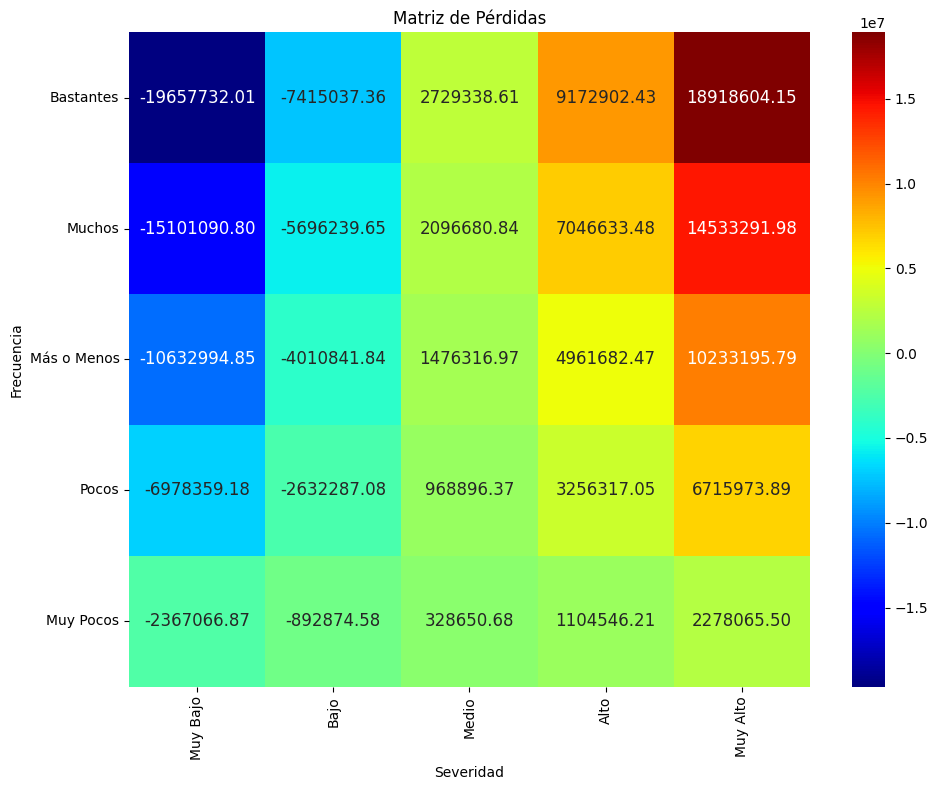

In [ ]:
MP_ordenada= MP[::-1,:] #Inversión Vertical

#Reorganizamos también las etiquetas de frecuencia en el mismo orden
lbf_ordenada = lbf[::-1]

#Graficamos
plt.figure(figsize=(10, 8))  # Adjust (10, 8) to your preferred size

sns.heatmap(MP_ordenada, annot=True, cmap='jet', fmt='.2f',
            annot_kws={"fontsize": 12})  # Increase font size
plt.title('Matriz de Pérdidas')
plt.xlabel('Severidad')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(len(lbs))+ 0.5,lbs, rotation=90)
plt.yticks(np.arange(len(lbf_ordenada)) + 0.5, lbf_ordenada, rotation=0)
plt.tight_layout()
plt.show()

#Muestreo de variables. Confiabilidad 99,9%

In [ ]:
dff = pd.DataFrame(XDB[:, 0])
dfs = pd.DataFrame(XDB[:, 1])
Xfm, Xsm = muestreo_variables(dff, dfs)

#Estimar distribuciones de las perdidas

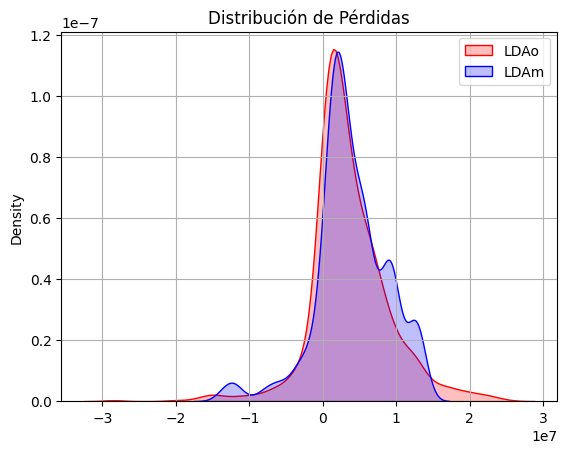

In [ ]:
XLDA, XLDAm = estimar_distribuciones_perdidas(Xfm, Xsm, XCf, XCs, sigmaf, sigmas, MP)

for k in range(1000):
  #print(k, Xfm[k], Xsm[k], Xfm[k]*Xsm[k])
  VPf = np.exp(-0.5*((XCf-Xfm[k])/sigmaf)**2)
  VPs = np.exp(-0.5*((XCs-Xsm[k])/sigmas)**2)
  MB= np.outer(VPf, VPs) #Matriz Borrosa

  #Buscamos los puntos de máximo pertenencia
  VMB = np.array(sorted(MB.flatten(), reverse= True))
  MT = np.zeros((5,5))

  for i in range(4):              #Digame donde están los 4 valores de pertenencia más grandes
    MT[np.where(MB==VMB[i])] = 1
    XLDAm[k]=np.sum(MP*MB*MT)/np.sum(MB*MT) #Pérdida Borrosa - Estructura Estadística de las Variables
    XLDA[k]= Xfm[k]*Xsm[k] #Pérdida Matemática Simple

plt.figure()
sns.kdeplot(x=XLDA.flatten(), fill= True, color='red', label='LDAo')
sns.kdeplot(x=XLDAm.flatten(), fill= True, color='blue', label='LDAm')
plt.title('Distribución de Pérdidas')
plt.legend()
plt.grid()
plt.show()

#Respositorio matrices de impacto y gestion

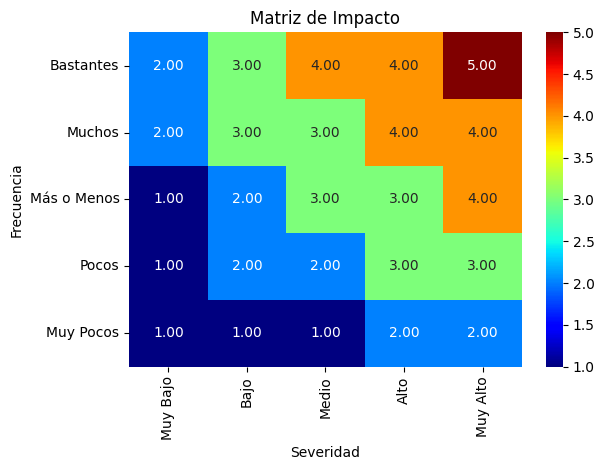

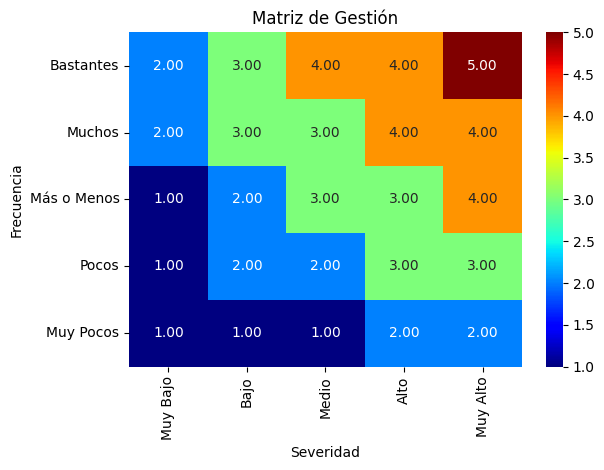

In [ ]:
#Se crea la matriz de impacto
MI=np.array([[1,1,1,2,2],
             [1,2,2,3,3],
             [1,2,3,3,4],
             [2,3,3,4,4],
             [2,3,4,4,5]])

MI_ordenada= MI[::-1, :]

#La matriz de gestión es utilizada para mitigar el impacto
NG=1 #Nivel de Gestion 1
MG=MI.astype(float).copy()  #Matriz de Gestión
MG[(MG>1)& (MG<5)]*=NG
MG_ordenada= MG[::-1, :]

#Matriz de Impacto
plt.figure()
sns.heatmap(MI_ordenada, annot=True, cmap='jet', fmt= '.2f')
plt.title('Matriz de Impacto')
plt.xlabel('Severidad')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(len(lbs))+ 0.5,lbs, rotation=90)
plt.yticks(np.arange(len(lbf_ordenada)) + 0.5, lbf_ordenada, rotation=0)
plt.tight_layout()

#Matriz de Gestión
plt.figure()
sns.heatmap(MG_ordenada, annot=True, cmap='jet', fmt= '.2f')
plt.title('Matriz de Gestión')
plt.xlabel('Severidad')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(len(lbs))+ 0.5,lbs, rotation=90)
plt.yticks(np.arange(len(lbf_ordenada)) + 0.5, lbf_ordenada, rotation=0)
plt.tight_layout()

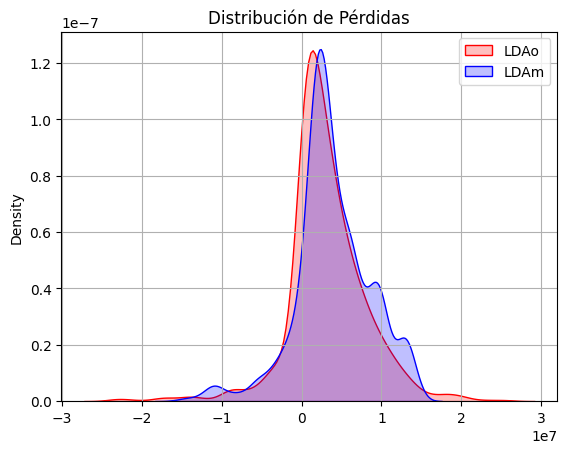

In [ ]:
#Distribución de Pérdidas con MI y MG

#DataFrame de Frecuencia
dff= pd.DataFrame(XDB[:,0])

#DataFrame de Severidad
dfs= pd.DataFrame(XDB[:,1])

#Se procede con el muestreo
Xfm= np.array(dff.sample(n=1000, replace= True))
Xsm= np.array(dfs.sample(n=1000, replace= True))

#Distribución agregada de las Pérdidas - Loss Distribution Approach
XLDAm= np.zeros((1000,1))#Distribución agregada de pérdidas borrosa
XLDA= np.zeros((1000,1)) #Distribución agregada de pérdidas original

for k in range(1000):
  #print(k, Xfm[k], Xsm[k], Xfm[k]*Xsm[k])
  VPf = np.exp(-0.5*((XCf-Xfm[k])/sigmaf)**2)
  VPs = np.exp(-0.5*((XCs-Xsm[k])/sigmas)**2)
  MB= np.outer(VPf, VPs) #Matriz Borrosa

  #Buscamos los puntos de máximo pertenencia
  VMB = np.array(sorted(MB.flatten(), reverse= True))
  MT = np.zeros((5,5))

  for i in range(4):              #Digame donde están los 4 valores de pertenencia más grandes
    MT[np.where(MB==VMB[i])] = 1

  XLDAm[k]=np.sum(MP*MB*MT*MI)/np.sum(MB*MT*MG) #Pérdida Borrosa - Estructura Estadística de las Variables
  XLDA[k]= Xfm[k]*Xsm[k] #Pérdida Matemática Simple

plt.figure()
sns.kdeplot(x=XLDA.flatten(), fill= True, color='red', label='LDAo')
sns.kdeplot(x=XLDAm.flatten(), fill= True, color='blue', label='LDAm')
plt.title('Distribución de Pérdidas')
plt.legend()
plt.grid()
plt.show()

#Metricas

In [ ]:
#Importamos Librerias Adicionales
from scipy.stats import skew

#Asimetría
valor_skew_m= skew(XLDAm)
print('Skew Gestionados:', valor_skew_m)
valor_skew = skew(XLDA)
print('Skew Originales:', valor_skew)

#Pérdidas Esperadas
u_m = np.mean(XLDAm)
print('Pérdidas Esperadas Gestionados:', u_m)
u = np.mean(XLDA)
print('Pérdidas Esperadas Originales:', u)

#OpVar (Péridas Catastróficas)
OpVar_m= np.percentile(XLDAm, 0.999)
print('OpVar Gestionados:', OpVar_m)
OpVar= np.percentile(XLDA, 0.999)
print('OpVar Originales:', OpVar)

#Pérdidas No Esperadas
PNE_m = (u_m+OpVar_m)/2
print('Pérdidas No Esperadas Gestionados:', PNE_m)
PNE = (u+OpVar)/2
print('Pérdidas No Esperadas Originales:', PNE)

Skew Gestionados: [-0.39099731]
Skew Originales: [-0.2616195]
Pérdidas Esperadas Gestionados: 3812749.7190078525
Pérdidas Esperadas Originales: 3108508.606315246
OpVar Gestionados: -11084922.771720402
OpVar Originales: -13853512.738447402
Pérdidas No Esperadas Gestionados: -3636086.5263562747
Pérdidas No Esperadas Originales: -5372502.066066078


#**Analisis de resultados**

Con base a los resultados obtenidos para la Zona de Estudio I del sector palmero, se construyó la matriz de pérdidas utilizando los clusters derivados de las variables de frecuencia y severidad, categorizados respectivamente en niveles como "Muy Pocos" a "Bastantes" y "Muy Bajo" a "Muy Alto". A partir del análisis de las distribuciones agregadas de pérdidas, se evidencia que al aplicar una gestion 1 en 1, es decir, sin intervención adicional, se obtuvieron pérdidas esperadas de 3.108.508,6.  Mientras que bajo la gestión mediante muestreo (confiabilidad del 99,9%), las pérdidas esperadas aumentaron ligeramente a 3.812.749,71. No obstante, el OpVar (percentil 99,9%), que representa el peor escenario de perdida se redujo de -13.853.512,73 a -11.084.922,77, lo cual sugiere una mejora en el control de eventos catastróficos. A su vez, las pérdidas no esperadas también se redujeron, pasando de -5.372.502,06 a -3.636.086,52. El coeficiente de asimetria pasó de (-0,26) en la distribución original a (-0,39) en la gestionada, lo que indica un cambio en la forma de la distribución hacia una mayor concentración de perdidas leves. Este comportamiento refuerza la utilidad de aplicar técnicas de simulación y gestión del riesgo para mitigar el impacto de perdidas extremas en un horizonte anual.